In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler


/home/kunj/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")

In [4]:
print("\n--- Missing Values ---")
print(customers.isnull().sum())
print(products.isnull().sum())
print(transactions.isnull().sum())


--- Missing Values ---
CustomerID      0
CustomerName    0
Region          0
SignupDate      0
dtype: int64
ProductID      0
ProductName    0
Category       0
Price          0
dtype: int64
TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
dtype: int64


In [5]:
print("\n--- Data Types ---")
print(customers.dtypes)
print(products.dtypes)
print(transactions.dtypes)



--- Data Types ---
CustomerID      object
CustomerName    object
Region          object
SignupDate      object
dtype: object
ProductID       object
ProductName     object
Category        object
Price          float64
dtype: object
TransactionID       object
CustomerID          object
ProductID           object
TransactionDate     object
Quantity             int64
TotalValue         float64
Price              float64
dtype: object


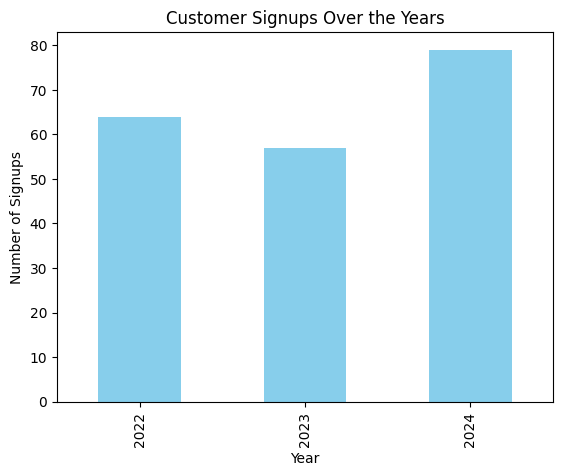

In [6]:
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
customers['Year'] = customers['SignupDate'].dt.year
signup_trends = customers['Year'].value_counts().sort_index()
signup_trends.plot(kind='bar', title='Customer Signups Over the Years', color='skyblue')
plt.xlabel('Year')
plt.ylabel('Number of Signups')
plt.show()

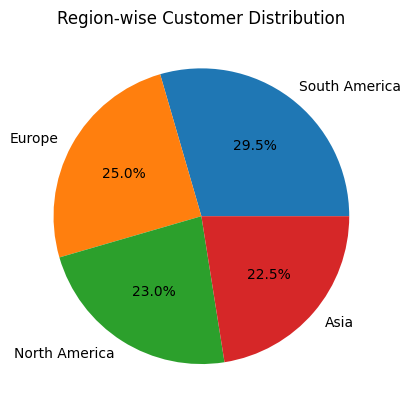

In [7]:
region_distribution = customers['Region'].value_counts()
region_distribution.plot(kind='pie', autopct='%1.1f%%', title='Region-wise Customer Distribution')
plt.ylabel('')
plt.show()


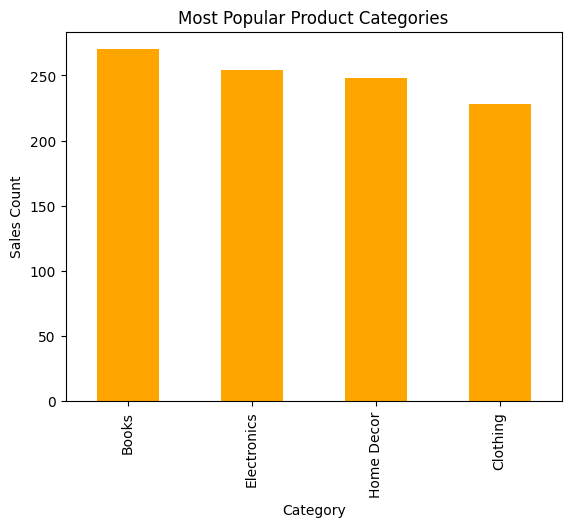

In [8]:
popular_products = products.merge(transactions, on='ProductID')
category_sales = popular_products['Category'].value_counts()
category_sales.plot(kind='bar', title='Most Popular Product Categories', color='orange')
plt.xlabel('Category')
plt.ylabel('Sales Count')
plt.show()

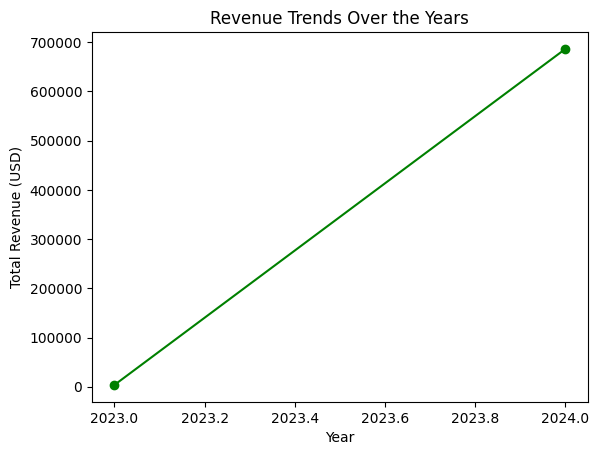

In [9]:
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
transactions['Year'] = transactions['TransactionDate'].dt.year
revenue_per_year = transactions.groupby('Year')['TotalValue'].sum()
revenue_per_year.plot(kind='line', marker='o', title='Revenue Trends Over the Years', color='green')
plt.xlabel('Year')
plt.ylabel('Total Revenue (USD)')
plt.show()

In [10]:
customer_transactions = transactions.merge(products, on='ProductID').merge(customers, on='CustomerID')
customer_summary = customer_transactions.groupby(['CustomerID', 'ProductID']).agg({
    'Quantity': 'sum',
    'TotalValue': 'sum'
}).reset_index()

In [11]:
customer_product_matrix = customer_summary.pivot_table(index='CustomerID', columns='ProductID', values='TotalValue', fill_value=0)


In [12]:
scaler = StandardScaler()
customer_product_normalized = scaler.fit_transform(customer_product_matrix)

In [13]:
similarity_matrix = cosine_similarity(customer_product_normalized)
similarity_df = pd.DataFrame(similarity_matrix, index=customer_product_matrix.index, columns=customer_product_matrix.index)


In [14]:
def get_top_similar(customers_df, target_customer, top_n=3):
    similar_customers = customers_df[target_customer].sort_values(ascending=False)[1:top_n+1]
    return [(customer, round(score, 4)) for customer, score in similar_customers.items()]


In [15]:
lookalike_data = {}
for customer_id in similarity_df.index[:20]:
    lookalike_data[customer_id] = get_top_similar(similarity_df, customer_id)


In [16]:
lookalike_output = []
for customer, similar_customers in lookalike_data.items():
    for similar_customer, score in similar_customers:
        lookalike_output.append({
            'CustomerID': customer,
            'SimilarCustomerID': similar_customer,
            'SimilarityScore': score
        })

lookalike_df = pd.DataFrame(lookalike_output)

In [17]:
lookalike_df.to_csv('Kunj_shukla_Lookalike.csv', index=False)


In [18]:
print(lookalike_df.head())

  CustomerID SimilarCustomerID  SimilarityScore
0      C0001             C0194           0.4049
1      C0001             C0104           0.3740
2      C0001             C0020           0.3666
3      C0002             C0030           0.4046
4      C0002             C0091           0.3838
